# Getting started with the CEDA STAC API

This notebook outlines how to start using the EODH STAC API, using the `pyeodh` python package. Note that the pyeodh [documentation](https://pyeodh.readthedocs.io/en/latest/) is also avialable.


## 1. Pystac-client
First we import `pyeodh` library.

In [1]:
import pyeodh

Now we make our client

In [2]:
client = pyeodh.Client().get_catalog_service()

And now we can start making calls to it. First up we can examine the collections available:

In [3]:
for coll in client.get_collections():
    print(f"{coll.id}: {coll.description}")

cmip6: CMIP6
cordex: CORDEX
ukcp: UKCP
0fcb2296-2411-11ef-bcbd-da6b61b15d6d: description
93cdafea-1dc8-11ef-968f-6a7abc48984c: description
97d80a3c-1dc7-11ef-92a3-6a7abc48984c: description
ad608ce4-1d0e-11ef-8036-563e2ce721d4: description
1440d164-1376-11ef-b8ab-e20b664dd0f8: description
093927f4-12ad-11ef-94e9-7e375e8a9c97: description
sentinel2_ard: sentinel 2 ARD


We can take a closer look at the Sentinel 2 ARD collection by referencing its id with the `get_collection()` method, grabbing it from the respective catalog.

In [4]:
sentinel2_ard = client.get_catalog("supported-datasets/ceda-stac-catalogue").get_collection('sentinel2_ard')

We _could_ grab all it's related items like this but it would grab _ALL_ the items. We don't recommend it, this is better handled by searching - more on that later. 

In [5]:
sentinel2_ard.get_items()

Note: just calling `get_items()` only creates a generator, we'd have to iterate over it to actually get all the items, i.e. 
```python
for item in sentinel2_ard.get_items():
    do stuff
```
but we're not doing that here. 

What we can do is check the spatial and temporal extent of the collection like so

In [6]:
sentinel2_ard.extent.spatial.bboxes

[[-9.00034454651177, 49.48562028352171, 3.1494256015866995, 61.33444247301668]]

In [7]:
[str(d) for d in sentinel2_ard.extent.temporal.intervals[0]]

['2023-01-01 11:14:51+00:00', '2023-11-01 11:43:49+00:00']

So we can see we have the satellite data between the 1st of Jan and 1st of November 2023, over the UK.

## 2. Searching

To make sure we're only looking at the items of interest we can use the search endpoint to slim down our possibilities, either using spatio-temporal values or other item-specific properties. This is all outlined [here](https://github.com/radiantearth/stac-api-spec/tree/release/v1.0.0/item-search), but we can show some of the features off here. 

Firstly temporal filtering, say we wanted to only get images from sentinel from January and February 2023, we would use the `client.search()` method, there are two kinds of datetime selection methods we can use:

In [8]:
item_search = client.search(
    collections=['sentinel2_ard'],
    datetime="2023-01-01/2023-02-28",
    catalog_paths=["supported-datasets/ceda-stac-catalogue"],
    limit=10,
)

This is the standard way of doing a datetime search with the pystac client, as satellite images are, generally speaking, a single datetime and so this will return records between the two datetimes given (separated by a slash).

An alternative method, which is more relevant to a generic search across both satellite images and model data, is:

In [3]:
item_search = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["supported-datasets/ceda-stac-catalogue"],
    query=[
        'start_datetime>=2023-11-01',
        'end_datetime<=2023-12-28', 
    ],
    limit=10,
)

Here we've used the query kwarg to specify the start and end datetime for our search range, and these are all _and_-ed together so we get the range we want. Note as well that we've set `limit` to 10 so we don't end up grabbing every item in the search result, you could remove this if you so desired. We've only specified one collection here but you can specify multiple, just bear in mind you always need to specify your collection(s) as a list - even if there's only one. 

We can interrogate our search results and see how many we matched:

In [4]:
print(item_search.total_count)



10


We can now loop through and look at the metadata if we want to.

In [11]:
for item in item_search:
    print(item.properties["start_datetime"], item.properties["end_datetime"])

2023-11-21T11:43:49+00:00 2023-11-21T11:43:49+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00
2023-11-20T11:23:51+00:00 2023-11-20T11:23:51+00:00


If we inspect the properties of the first item we retrieved, we can see the associated metadata.  Every field here can be searched across with the query kwarg in `client.search()` (which we previously did with `start_datetime` and `end_datetime`)

In [12]:
item_search[0].properties

{'start_datetime': '2023-11-21T11:43:49+00:00',
 'end_datetime': '2023-11-21T11:43:49+00:00',
 'datetime': '2023-11-21T11:43:49+00:00'}

So we can now do a slightly more interesting/complicated search using some of this metadata. First we define a point in space, and the shapely library provides some useful utilities for doing so. Note that the [stac spec](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#bbox) states that the bbox or coordinates must be specified in order of longitude-lattitude(-elevation) in line with the [GeoJSON standard RFC7946](https://datatracker.ietf.org/doc/html/rfc7946#section-5).

In [7]:
from shapely import Point
point = Point(-1.3144835766058023, 51.57555380377267) # Atlas building at RAL

This is using lattitude and longitude, but there is no required coordinate system built into STAC, so this is dependent entirely on the data you are trying to access. We're also only using a point in this example, but this could be an arbitrary bounding box or shape if you like. 

Lets do a search using this and a little more metadata. We input our spatial data using the `intersects` kwarg, and filter on the `Cloud Coverage Assessment` using the `query` kwarg as before.

In [14]:
items = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["supported-datasets/ceda-stac-catalogue"],
    intersects=point,
    query=[
        'start_datetime>=2023-11-01',
        'end_datetime<=2023-12-28', 
        'Cloud Coverage Assessment<=50.0'
    ],
    limit=10,
)

In [15]:
items.total_count

1

So we've narrowed down quite a bit further. If you want more information on alternative ways to search or query there is good documentation available online, e.g. [here](https://pystac-client.readthedocs.io/en/latest/usage.html#query-extension), [here](https://github.com/stac-api-extensions/query), and [here](https://github.com/radiantearth/stac-api-spec/blob/release/v1.0.0/item-search/examples.md).

In [16]:
for item in items:
    print(item)

## 3. From items to assets

Now we have some items that we're keen on, we can take a closer look and actually load some of the data. First lets have a look at the json object. 

In [17]:
items[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb',
 'properties': {'start_datetime': '2023-11-20T11:23:51+00:00',
  'end_datetime': '2023-11-20T11:23:51+00:00',
  'datetime': '2023-11-20T11:23:51Z',
  'Cloud Coverage Assessment': '21.15911075158'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-0.710780290757853, 52.32554535096241],
    [-0.761649699618816, 52.23063055732549],
    [-0.838258727319058, 52.08681020908176],
    [-0.914523909753917, 51.94298746285893],
    [-0.990004691890607, 51.79907720852261],
    [-1.065265953017197, 51.655131101519565],
    [-1.140368604605094, 51.51120171432583],
    [-1.214603329360477, 51.367205125071365],
    [-1.224443653947756, 51.34799258998802],
    [-1.56387937487654, 51.354439390266904],
    [-1.532115847042169, 52.34135509726958],
    [-0.710780290757853, 52.32554535096241]]]},
 'links': [{'rel': 'self',
   'href':

There's a lot there, feel free to browse at your own leisure. 

If we're interested in getting to the data we need to specifically look at the assets dictionary.

In [18]:
for key, value in items[0].assets.items():
    print(key, value.href)

cloud https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb_clouds.tif
cloud_probability https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb_clouds_prob.tif
cog https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif
metadata https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml
saturated_pixels https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb_sat.tif
thumbnail https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm3

The metadata is a little sparse at the moment, but we have here a list of the available files for this particular scene and links to them within the ceda catalog under the `.href` property (or key if you're accessing it as a dictionary). 

We can have a quick look at the thumbnail to see what we're looking at, using `matplotlib` and `urllib` to point to the remote jpg url.

In [19]:
asset_dict = items[0].assets

# Get the url as a string
thumbnail_assets = [v for k, v in asset_dict.items() if 'thumbnail' in k]
thumbnail_url = thumbnail_assets[0].href
thumbnail_url

'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg'

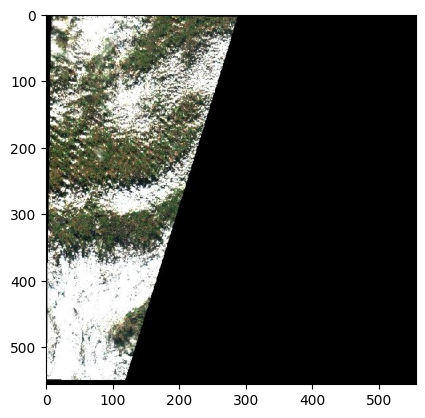

In [20]:
import matplotlib.pyplot as plt
import urllib
import numpy as np
from PIL import Image

# Some magic using pillow and urllib to open the remote jpg as a file handle in memory 
thumbnail = np.array(Image.open(urllib.request.urlopen(thumbnail_url)))

plt.imshow(thumbnail)

And we can load the geotiff in a similar fashion, using in this case the actual data file. Here I make an assumption about the name of the necessary asset based on the standard sentinel naming structure in our stac catalog (note: the keys on the asset dictionary may change in future updates to our STAC API).

In [21]:
data_file_url = asset_dict['cog'].href
data_file_url

'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn518lonw0008_T30UXC_ORB037_20231120132420_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif'

We can lazily load the geotiff with rioxarray, which will pull in the metadata from the url and only load when we want it to. All the sentinel2 data in our STAC catalogue is in Cloud-optimised Geotiff (COG) format, so it has several different layers of different resolutions that we can look at. In this case we tell rioxarray to load a lower resolution version of the image.

In [22]:
import rioxarray

rds = rioxarray.open_rasterio(data_file_url, overview_level=3)
rds

<xarray.DataArray (band: 10, y: 695, x: 695)> Size: 10MB
[4830250 values with dtype=uint16]
Coordinates:
  * band         (band) int64 80B 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 6kB 4.305e+05 4.307e+05 ... 5.415e+05 5.417e+05
  * y            (y) float64 6kB 2.715e+05 2.713e+05 ... 1.605e+05 1.604e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

If the above has worked you should now see a summary of the dataset. It has 10 695x676 images in it corresponding to one for each band. If we look in the attributes we can often see that the name of each band is displayed in the `long_name` key, though sometimes you may have to dig through the metadata xml file to get that information. 

If necessary, we could get the metadata xml file name from the assets like so: 

In [23]:
meta_assets = [v for k, v in asset_dict.items() if 'metadata' in k]
meta_file_url = meta_assets[0].href


And then use something like `beautiful_soup` to parse the xml and find the band information. 

For now though, we can just take a quick look at one of the bands – 7: near infrared – with the following:  
**warning: this can take a while depending on your internet connection**

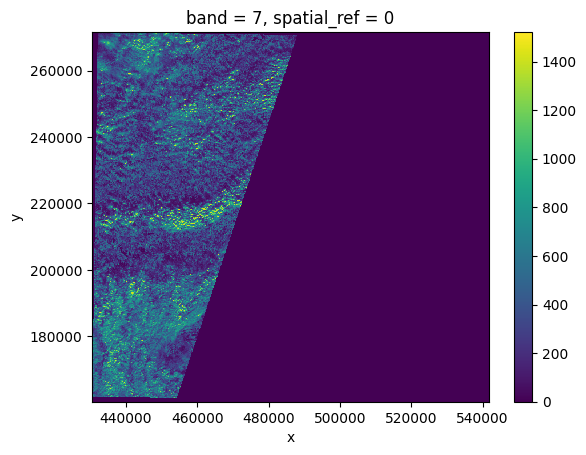

In [24]:
# Band=7 in this corresponds to the nir band
rds.sel(band=7).plot()

This can now be manipulated to your hearts content, potentially with the missing values masked out etc. 

## 4. Searching and using NetCDF data

We can construct a search for NetCDF data in much the same way we constructed one for sentinel data. First we can grab the CMIP6 collection to get an idea of what we're looking at

In [25]:
cmip6_coll = client.get_catalog("supported-datasets/ceda-stac-catalogue").get_collection('cmip6')
cmip6_coll.extent.to_dict()

{'spatial': {'bbox': [[-180.0, -90.0, 179.99999991618097, 89.99999995809048]]},
 'temporal': {'interval': [['1850-01-01T00:00:00Z', '4114-12-16T12:00:00Z']]}}

Here we construct a search call where we specify start and end datetime as before, but because CMIP datasets are wide we're trying to make sure our month of October is within teh start and end datetime, rather than last time where we wanted satellite images, taken at a single point in time, which occurred within our month. I'm also specifying an experiment here so we can see the different items available for a given run of a model.

Note we're using the same point we defined before. 

In [8]:
item_search = client.search(
    collections=['cmip6'],
    catalog_paths=["supported-datasets/ceda-stac-catalogue"],
    intersects=point,
    query=[
        'start_datetime<=2251-01-01',
        'end_datetime>=2251-02-28',
        'experiment_id=ssp585',
    ],
    limit=10,
)



In [9]:
item_search.total_count

5

And our reduced list of items looks like:

In [10]:
item_search.get_limited()

We can take a look at a particular item and the assets associated with it

In [11]:
item = item_search[0]
item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.r1i1p1f1.day.pr.gn.v20210317',
 'properties': {'start_datetime': '2251-01-01T12:00:00+00:00',
  'end_datetime': '2300-12-31T12:00:00+00:00',
  'datetime': '2276-01-01T00:00:00Z',
  'experiment_id': 'ssp585'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-179.0625, -89.375],
    [179.0625, -89.375],
    [179.0625, 89.375],
    [-179.0625, 89.375],
    [-179.0625, -89.375]]]},
 'links': [{'rel': 'self',
   'href': 'https://test.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/ceda-stac-catalogue/collections/cmip6/items/CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.r1i1p1f1.day.pr.gn.v20210317',
   'type': 'application/geo+json'},
  {'rel': 'parent',
   'href': 'https://test.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/ceda-stac-catalogue/collections/cmip6',
   'type': 'application/json'},
  {'rel': 'collection',
   'href': 'https://test.eodat

In [30]:
item.assets

{'reference_file': <Asset href=https://dap.ceda.ac.uk/badc/cmip6/metadata/kerchunk/pipeline1/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/kr1.0/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_r1i1p1f1_day_pr_gn_v20210317_kr1.0.json>,
 'data0001': <Asset href=https://dap.ceda.ac.uk/badc/cmip6/data/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/day/pr/gn/v20210317/pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_22510101-23001231.nc>}

In [31]:
# Get the first asset whose href ends in '.nc'
nc_assets = [v.href for k, v in item.assets.items() if v.href[-3:]=='.nc']
nc_file_url = nc_assets[0]
nc_file_url

'https://dap.ceda.ac.uk/badc/cmip6/data/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/day/pr/gn/v20210317/pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_22510101-23001231.nc'

As you can see, we only have two assets:
1. A reference file 
2. The netcdf file containing the data we want

Now we want to open that .nc file that contains the data, but there's not many nice ways to load NetCDF files over the internet without just downloading the whole thing. Ideally there would be a kerchunk file present to provide an index to the file to slice only the bits you want, and CEDA is currently working towards providing this solution but it's not quite ready yet. We could also provide zarr files which offer a nice soltuion to this, but would require making copies of all of the netcdf files currently stored in the CEDA archive, which we have no current plans to do. 

So in the mean time the only solutions we have are to either access the file on a machine which has the file mounted (the JASMIN notebook service would be a good candidate) or to simply download the file. You can also choose to stream a whole netcdf file remotely by appending `"#mode=bytes"` to the filename when using xarray's `open_dataset` method, like so:

```python
import xarray as xr

ds = xr.open_dataset(f"{nc_file_url}#mode=bytes")
```

But we won't execute this here as it will read the whole netcdf file into memory, which will take a long time.

---
## Kerchunk example

The following is an example of how to use a kerchunk file that has been generated for some specific CMIP data, which can be used to index only the parts of the netcdf file you want to work with as opposed to the whole thing. To do this we use fsspec to read the kerchunk file as a virtual zarr file, and then open it using xarray's `open_zarr()` method. We can then select a subset of data and it works in a fraction of the time doing something equivalent with the above `open_dataset` method would take.  

Note that kerchunk is only one method of doing this, alternatives (cfa, pure zarr files, etc.) do exist and can be used to similar effect, we will hopefully update both our stac records and this notebook with examples of how to use these. 

NOTE: This is a very specific search for a specific dataset which has an associated kerchunk file. We are working towards all datasets having kerchunk files, but this is a useful showcase for which properties are useful to search on for cmip datasets.

In [32]:
items = client.search(
    collections=['cmip6'],
    catalog_paths=["supported-datasets/ceda-stac-catalogue"],
    intersects=point,
    query=[
        "mip_era=CMIP6",
        "activity_id=CMIP",
        "institution_id=AS-RCEC",
        "source_id=TaiESM1",
        "experiment_id=historical",
        "variant_label=r1i1p1f1",
        "frequency=mon",
        "variable_id=clt",
    ],
    limit=10,
)

As this was a very specific search, we've ended up with a single item. We could relax the search a little by, say, not specifying a variable or frequency, and you would end up with many more items which you could stitch together. 

Anyhow, we can have a look at the associated assets in the normal way:

In [33]:
item = items[0]
item.assets

IndexError: list index out of range

Here the `reference_file` is the kerchunk file, which we can have a look at more closely

In [ ]:
kc_file = item.assets['reference_file']
kc_file.to_dict()

{'href': 'https://dap.ceda.ac.uk/badc/cmip6/metadata/kerchunk/pipeline1/CMIP/AS-RCEC/TaiESM1/kr1.0/CMIP6_CMIP_AS-RCEC_TaiESM1_historical_r1i1p1f1_Amon_clt_gn_v20200623_kr1.0.json',
 'type': 'application/zstd',
 'size': None,
 'open_zarr_kwargs': {'decode_times': True},
 'checksum': None,
 'checksum_type': None,
 'roles': ['reference', 'data']}

Which has the `href` to our served kerchunk file as well as the additional property `open_zarr_kwargs` which we will pass to xarray later on when we're opening the file for manipulation.

In [ ]:
kc_file_uri = kc_file.href
kc_file_uri

'https://dap.ceda.ac.uk/badc/cmip6/metadata/kerchunk/pipeline1/CMIP/AS-RCEC/TaiESM1/kr1.0/CMIP6_CMIP_AS-RCEC_TaiESM1_historical_r1i1p1f1_Amon_clt_gn_v20200623_kr1.0.json'

In [ ]:
zarr_kwargs = kc_file.to_dict()['open_zarr_kwargs']

And now we can use this uri to open the kerchunk file remotely as a virtual zarr file, and can now feed the `kwargs` we obtained previously into the `open_zarr` method. 

In [ ]:
import xarray as xr
import fsspec

mapper = fsspec.get_mapper("reference://", fo=kc_file_uri, remote_protocol='https')
ds = xr.open_zarr(mapper, consolidated=False, **zarr_kwargs)

NameError: name 'kc_file_uri' is not defined

Then we can inspect our dataset and plot something from it

In [ ]:
ds

<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    clt        (time, lat, lon) float32 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/50)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 0671-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     171550.0
    ...                        ...
    table_id:                  Amon
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     TaiESM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/44bd0757-487f-45b7-9e65-e7241afa7d27
    variable_id:               clt
    variant_label:             r1i1p1f1

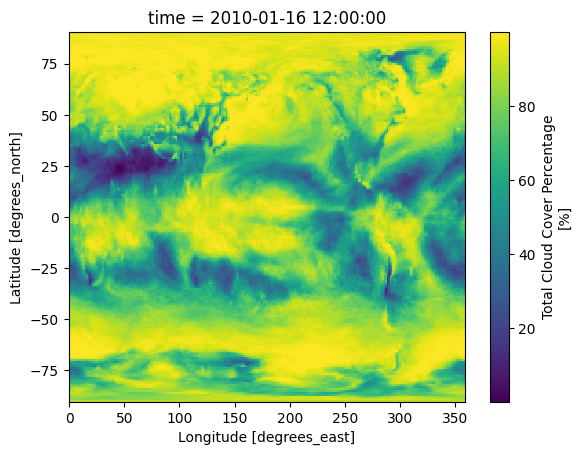

In [ ]:
ds.sel(time='2010-01').isel(time=0).clt.plot()

Which clearly works more quickly than the `open_dataset()` method described above. 